In [35]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
%matplotlib inline

In [36]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])

In [37]:
data_train = datasets.MNIST(root = "./data/",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

In [38]:
data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 64,
                                                shuffle = True,
                                                 num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 64,
                                               shuffle = True,
                                                num_workers=2)

In [39]:
print(len(data_train))

60000


In [40]:
images, labels = next(iter(data_loader_train))
# img = torchvision.utils.make_grid(images)

# img = img.numpy().transpose(1,2,0)
# std = [0.5]
# mean = [0.5]
# img = img*std+mean
# print([labels[i] for i in range(64)])


In [41]:
imgs = images.numpy()

In [52]:
imgs[0].shape

(1, 28, 28)

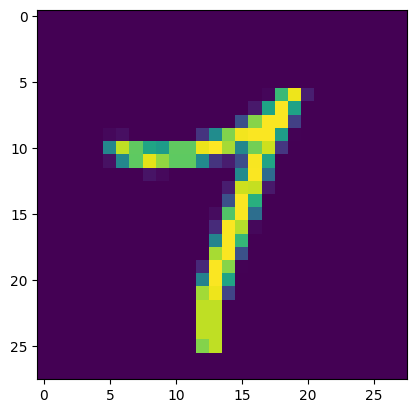

In [53]:
plt.imshow(imgs[0].transpose(1, 2, 0))

In [54]:
class Model(torch.nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(stride=2,kernel_size=2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(14*14*128,1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p=0.5),
                                         torch.nn.Linear(1024, 10))
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        x = x.view(-1, 14*14*128)
        x = self.dense(x)
        return x

In [55]:
model = Model()
model = model.cuda()

In [56]:
print(model)

Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [57]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 5

In [65]:
for epoch in range(n_epochs):
    running_loss = 0.0
    running_correct = 0
    print("Epoch {}/{}".format(epoch, n_epochs))
    print("-"*10)
    for data in data_loader_train:

        X_train, y_train = data
        X_train = X_train.to("cuda:0")
        y_train = y_train.to("cuda:0")
        X_train, y_train = Variable(X_train), Variable(y_train)
        
        
        outputs = model(X_train)
        _,pred = torch.max(outputs.data, 1)
        optimizer.zero_grad()
        loss = cost(outputs, y_train)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(pred == y_train.data)
    testing_correct = 0
    for data in data_loader_test:
        X_test, y_test = data
        X_test = X_test.to("cuda:0")
        y_test = y_test.to("cuda:0")
        X_test, y_test = Variable(X_test), Variable(y_test)
        outputs = model(X_test)
        _, pred = torch.max(outputs.data, 1)
        testing_correct += torch.sum(pred == y_test.data)
    print("Loss is:{:.4f}, Train Accuracy is:{:.4f}%, Test Accuracy is:{:.4f}".format(running_loss/len(data_train),
                                                                                      100*running_correct/len(data_train),
                                                                                      100*testing_correct/len(data_test)))

Epoch 0/5
----------
Loss is:0.0004, Train Accuracy is:99.2117%, Test Accuracy is:98.8300
Epoch 1/5
----------
Loss is:0.0003, Train Accuracy is:99.4383%, Test Accuracy is:98.6000
Epoch 2/5
----------
Loss is:0.0003, Train Accuracy is:99.4667%, Test Accuracy is:98.8400
Epoch 3/5
----------
Loss is:0.0002, Train Accuracy is:99.5950%, Test Accuracy is:98.9200
Epoch 4/5
----------
Loss is:0.0002, Train Accuracy is:99.6767%, Test Accuracy is:98.8700


In [66]:
torch.save(model.state_dict(), "model_parameter.pkl")

Predict Label is : [6, 0, 4, 6, 3, 4, 9, 3]
Real Label is    : [6, 0, 4, 6, 3, 4, 9, 3]


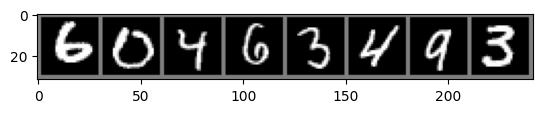

In [114]:
data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size = 8,
                                          shuffle = True)
X_test, y_test = next(iter(data_loader_test))
X_test = X_test.to("cuda:0")
y_test = y_test.to("cuda:0")

inputs = Variable(X_test)
pred = model(inputs)
pred = pred.to("cpu")
_,pred = torch.max(pred, 1)
y_test = y_test.cpu()
X_test = X_test.cpu()

print("Predict Label is :", [ i for i in pred.data.numpy()])
print("Real Label is    :",[i for i in y_test.numpy()])

img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)

std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean
plt.imshow(img)